In [1]:
import pandas as pd

In [2]:
#loading dataset

In [7]:
df=pd.read_csv('fake-news/train.csv')

# basic EDA---------------

In [8]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [15]:
df.head()

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# preprocessing------------------------(text to one_hot doc)------

In [16]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [17]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [24]:
corpus[0], len(corpus)

('hous dem aid even see comey letter jason chaffetz tweet', 18285)

In [26]:
#one hot representation

In [28]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=2500
onehot_repr=[one_hot(words,vocab_size)for words in corpus] 
onehot_repr[0:5]

[[1772, 608, 399, 43, 1520, 2194, 1021, 323, 1554, 352],
 [1701, 81, 166, 2060, 1577, 2163, 1592],
 [172, 891, 317, 1851],
 [2383, 2206, 24, 161, 2221, 1297],
 [1469, 1577, 1464, 80, 1460, 301, 1577, 2082, 660, 497]]

# model creation--------------------------

In [25]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

#### making each onr_hot doc sentence of equal size by padding--------------------------

In [31]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs), embedded_docs.shape

[[   0    0    0 ...  323 1554  352]
 [   0    0    0 ... 1577 2163 1592]
 [   0    0    0 ...  891  317 1851]
 ...
 [   0    0    0 ...  599 1739 1102]
 [   0    0    0 ... 2425  480 2448]
 [   0    0    0 ... 2408 1764  534]]


(None, (18285, 20))

In [40]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            100000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 156,501
Trainable params: 156,501
Non-trainable params: 0
_________________________________________________________________
None


###### one input shape--->(20,40) after embedding means one sentence has length 20 i.e, contains 20 words and each words are of 40 dimension. so the timestep of LSTM will be 20 and at the and of 20th timesteps a vector of dimension 100 will be the output because the selected hidden nodes are 100.

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedded_docs, df['label'], test_size=0.33, random_state=69)

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12250, 20), (12250,), (6035, 20), (6035,))

In [47]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 14s 71ms/step - loss: 0.1307 - accuracy: 0.9497 - val_loss: 0.2177 - val_accuracy: 0.9165
Epoch 2/10
192/192 [==============================] - 13s 68ms/step - loss: 0.1067 - accuracy: 0.9585 - val_loss: 0.2275 - val_accuracy: 0.9145
Epoch 3/10
192/192 [==============================] - 12s 64ms/step - loss: 0.0798 - accuracy: 0.9715 - val_loss: 0.2607 - val_accuracy: 0.9127
Epoch 4/10
192/192 [==============================] - 12s 64ms/step - loss: 0.0579 - accuracy: 0.9801 - val_loss: 0.2966 - val_accuracy: 0.9044
Epoch 5/10
192/192 [==============================] - 12s 63ms/step - loss: 0.0436 - accuracy: 0.9856 - val_loss: 0.3349 - val_accuracy: 0.9064
Epoch 6/10
192/192 [==============================] - 12s 65ms/step - loss: 0.0306 - accuracy: 0.9904 - val_loss: 0.3941 - val_accuracy: 0.8915
Epoch 7/10
192/192 [==============================] - 12s 65ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 0.4772 - val_accuracy:

# predictions----------------

In [48]:
prediction = model.predict(X_test)

In [56]:
prediction.shape, prediction.reshape(-1,).shape

((6035, 1), (6035,))

# visualizing predictions------------------

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
from sklearn import metrics

accuracy:   0.901
[[3114  330]
 [ 265 2326]]
Confusion matrix, without normalization


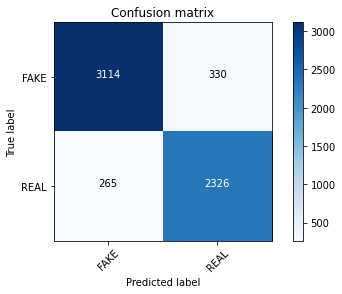

In [63]:
score = metrics.accuracy_score(y_test, prediction.round())
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, prediction.round())
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])